In [2]:
import cma
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.integrate import ode
from scipy.signal import butter, sosfiltfilt


In [6]:
# ==========================================
# CIRCUIT PARAMETERS
# ==========================================

wr_lo = (7.1501e9 + 0.126e6 - 0.12e6 - 0.37e6 + 0.01e6 - 0.06e6 - 0.05e6 - 0.04e6) * 2 * np.pi   # Resonator LO
wr_if = 50e6 * 2 * np.pi                            # Resonator IF  
wq_if = 251.73e6 * 2 * np.pi                        # Qubit IF
wq_lo = (4.39976e9) * 2 * np.pi                  # Qubit LO
chi = 0.64e6 * 2 * np.pi                             # Dispersive shift, cross non-linearity
k = 1.155e6 * 2 * np.pi                              # Resonator decay rate
T1 = 46 * 1e-6                                      # Qubit T1          
T2 = 20 * 1e-6                                      # Qubit T2 
phi = 0.0 * 2 * np.pi                               # Phase shift of drive

wr = wr_if + wr_lo                                  # Resonator frequency
wq = wq_if + wq_lo                                  # Qubit frequency
delta = abs(wr - wq)                                # Detuning between qubit and resonator

duration = 3000e-9                                  # Duration of the simulation       
dt = 1e-9                                          # Sampling time step 
tlist = np.arange(0, duration, dt) 

### AWG Generation of I/Q components for input into IQ mixer

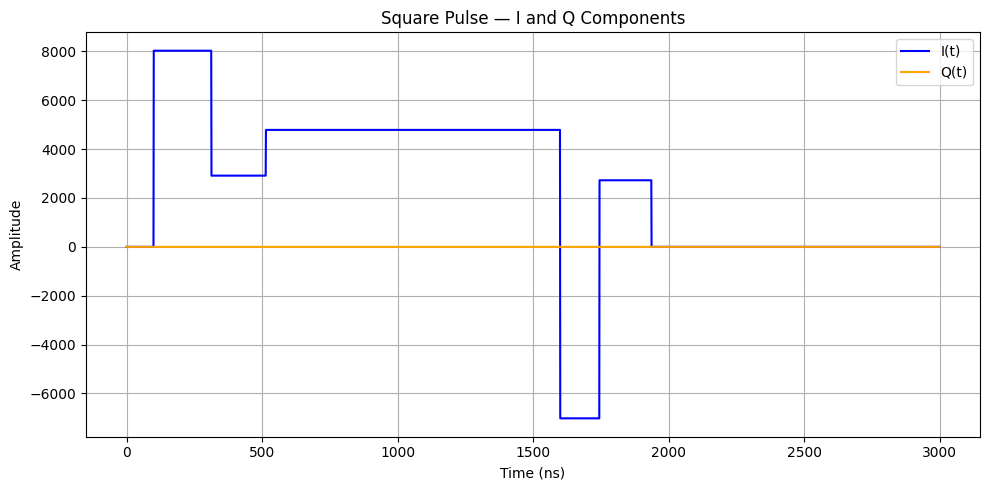

In [7]:
ringup1_amp = 8030.578922666127
ringdown1_amp = 2915.8789832213297
ringup2_amp = 2725.463506299161
drive_amp = 4788.1555658047455
ringdown2_amp = -7022.1711777914

optimal_ringup1_time = 212.87795414033954e-9
optimal_ringdown1_time = 200.41791524112293e-9
optimal_ringup2_time = 192.14763850644786e-9
optimal_ringdown2_time = 144.09414943757588e-9

pulse_start = 100e-9
pulse_width = 1500e-9

def smooth_ramp(t, T):
    return np.sin(np.pi * t / (2*T))  # cosine ramp

def smooth_ramp_reverse(t, T):
    return np.cos(np.pi * t / (2*T))

# ==========================================
# BASEBAND CLEAR PULSE
# ==========================================
def b_in(t):
    try:
        if  t<= pulse_start:
            return 0.0
        elif t<= pulse_start + optimal_ringup1_time:
            return ringup1_amp 
        elif t <= pulse_start + optimal_ringup1_time + optimal_ringdown1_time:
            return ringdown1_amp
        elif t <= pulse_start + pulse_width:
            return drive_amp
        elif t <= pulse_start + pulse_width + optimal_ringdown2_time:
            return ringdown2_amp 
        elif t <= pulse_start + pulse_width + optimal_ringdown2_time + optimal_ringup2_time:
            return ringup2_amp
        else:   
            return 0.0
    
    except Exception as e:
        print(f"b_in error at t={t}: {e}")
        return 0.0
    
envelope = np.array([b_in(t) for t in tlist.flatten()])

# I and Q components
I_t = np.real(envelope)
Q_t = np.imag(envelope)


plt.figure(figsize=(10, 5))

plt.plot(tlist/1e-9, I_t, label='I(t)', color='blue')
plt.plot(tlist/1e-9, Q_t, label='Q(t)', color='orange')
plt.title("Square Pulse — I and Q Components")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


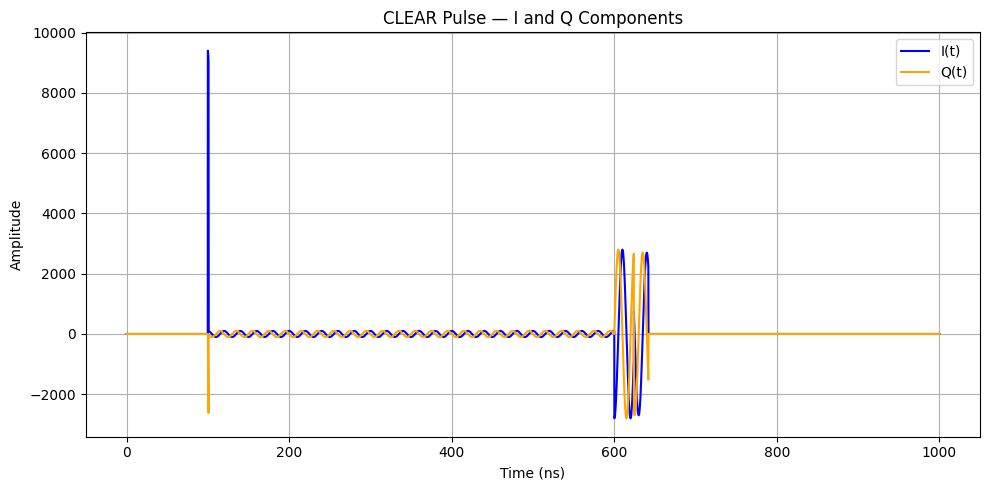

In [192]:
envelope = envelope * np.exp(-1j * (wr_if * tlist + phi))

# I and Q components
I_t = np.real(envelope)
Q_t = np.imag(envelope)


plt.figure(figsize=(10, 5))

plt.plot(tlist/1e-9, I_t, label='I(t)', color='blue')
plt.plot(tlist/1e-9, Q_t, label='Q(t)', color='orange')
plt.title("CLEAR Pulse — I and Q Components")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### I/Q Mixing of Envelope with LO for RF output

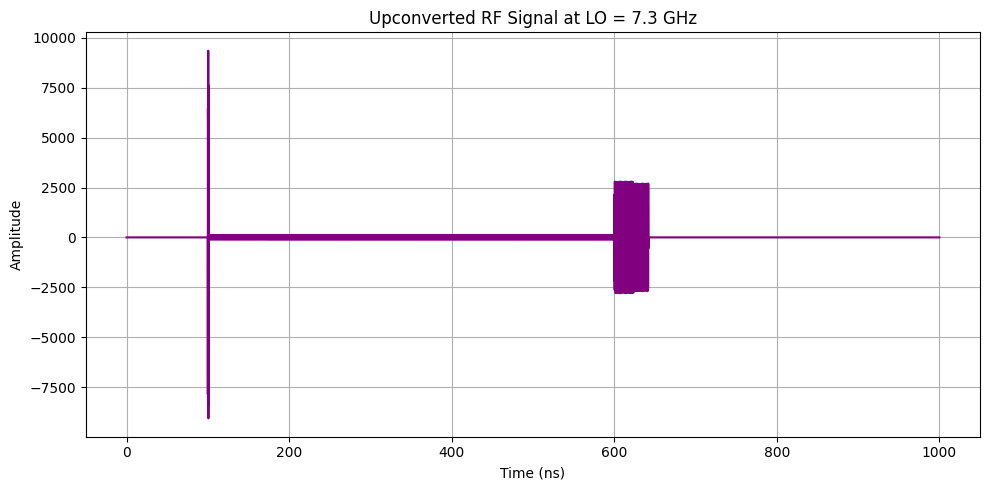

In [193]:
# RF signal must be real-valued (actual voltage)
lo_cos = np.cos(wr_lo * tlist)
lo_sin = np.sin(wr_lo * tlist)
RF_t = I_t * lo_cos - Q_t * lo_sin

plt.figure(figsize=(10, 5))
plt.plot(tlist/1e-9, RF_t, color='purple')
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.title(f"Upconverted RF Signal at LO = {wr_lo/(2*np.pi * 1e9):.1f} GHz")
plt.grid()

plt.tight_layout()
plt.show()

### Sanity check: Demodulation to retrieve original signal

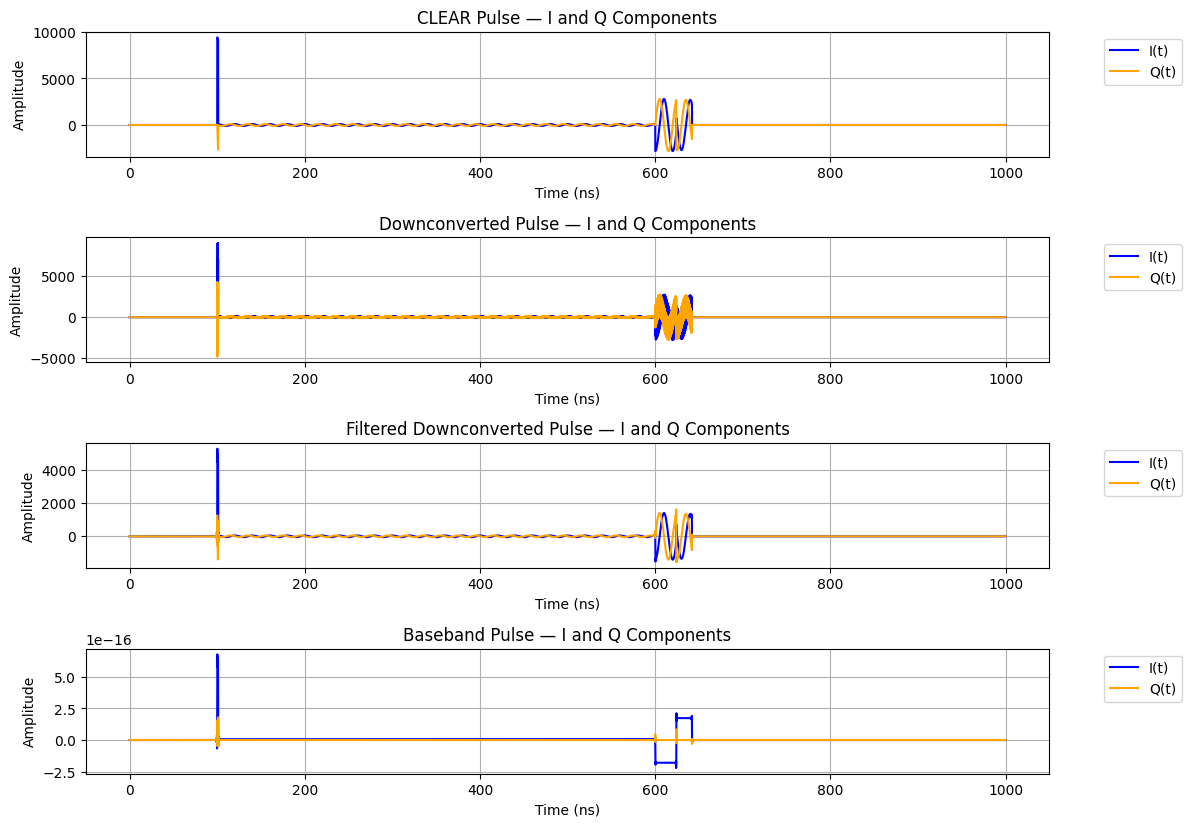

In [194]:
I_t_down = RF_t * lo_cos
Q_t_down = - RF_t * lo_sin

cutoff_frequency_lo = 2 * wr_lo/(2*np.pi) # Hz
sampling_rate_lo = 5e10 # Hz
order = 4

# Calculate normalized cutoff frequency
nyquist_frequency_lo = 0.5 * sampling_rate_lo
normalized_cutoff_lo = cutoff_frequency_lo / nyquist_frequency_lo

# Design the Butterworth filter
sos_lo = butter(order, normalized_cutoff_lo, btype='low', analog=False, output='sos')
I_t_filt = sosfiltfilt(sos_lo, I_t_down)
Q_t_filt = sosfiltfilt(sos_lo, Q_t_down)

V_t_filt = I_t_filt + 1j * Q_t_filt # Enters complex plane

V_t_base = V_t_filt * np.exp(1j * (wr_if * tlist + phi)) # Get back complex (actually just real) envelope

cutoff_frequency_if = 2 * wr_if/(2*np.pi) # Hz
sampling_rate_if = 5e10 # Hz
order = 4

# Calculate normalized cutoff frequency
nyquist_frequency_if = 0.5 * sampling_rate_if
normalized_cutoff_if = cutoff_frequency_if / nyquist_frequency_if

# Design the Butterworth filter
sos_if = butter(order, normalized_cutoff_if, btype='low', analog=True, output='sos')
I_t_env = 2 * sosfiltfilt(sos_if, np.real(V_t_base)) # Restore magnitude from downconversion
Q_t_env = 2 * sosfiltfilt(sos_if, np.imag(V_t_base))

plt.figure(figsize=(12, 10))

plt.subplot(5,1,1)
plt.plot(tlist/1e-9, I_t, label='I(t)', color='blue')
plt.plot(tlist/1e-9, Q_t, label='Q(t)', color='orange')
plt.title("CLEAR Pulse — I and Q Components")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

# Demodulate with LO, Contains second term that is a double-LO-frequency image
plt.subplot(5,1,2)
plt.plot(tlist/1e-9, I_t_down, label='I(t)', color='blue')
plt.plot(tlist/1e-9, Q_t_down, label='Q(t)', color='orange')
plt.title("Downconverted Pulse — I and Q Components")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

# Filtered out double-LO-frequency image, recovered original image
plt.subplot(5,1,3)
plt.plot(tlist/1e-9, I_t_filt, label='I(t)', color='blue')
plt.plot(tlist/1e-9, Q_t_filt, label='Q(t)', color='orange')
plt.title("Filtered Downconverted Pulse — I and Q Components")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

# Demodulate with LO, removes complex componen to get real pulse
plt.subplot(5,1,4)
plt.plot(tlist/1e-9, I_t_env, label='I(t)', color='blue')
plt.plot(tlist/1e-9, Q_t_env, label='Q(t)', color='orange')
plt.title("Baseband Pulse — I and Q Components")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

### Interaction with the readout resonator (Rotating Frame)

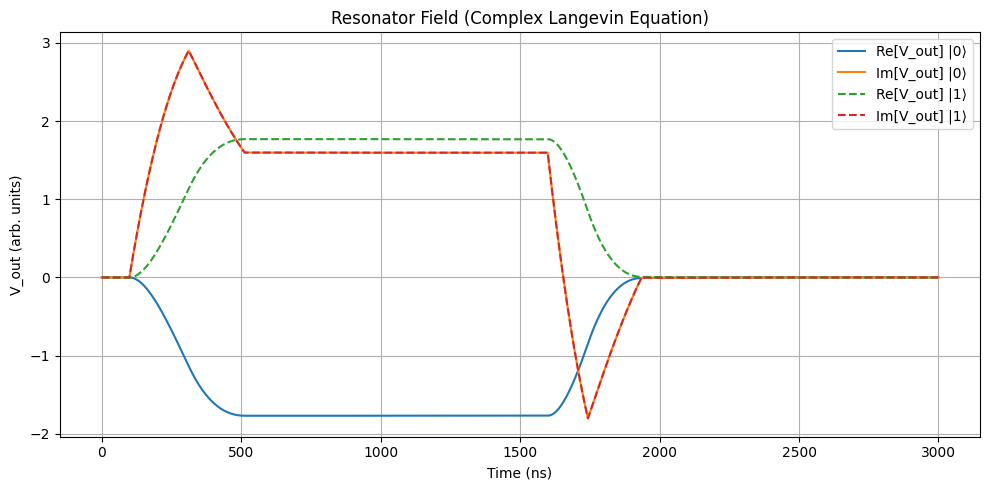

In [8]:
# Define drive
def b_in(t):
    try:
        if  t<= pulse_start:
            return 0.0
        elif t<= pulse_start + optimal_ringup1_time:
            return ringup1_amp 
        elif t <= pulse_start + optimal_ringup1_time + optimal_ringdown1_time:
            return ringdown1_amp
        elif t <= pulse_start + pulse_width:
            return drive_amp
        elif t <= pulse_start + pulse_width + optimal_ringdown2_time:
            return ringdown2_amp 
        elif t <= pulse_start + pulse_width + optimal_ringdown2_time + optimal_ringup2_time:
            return ringup2_amp
        else:   
            return 0.0
    
    except Exception as e:
        print(f"b_in error at t={t}: {e}")
        return 0.0
    
def qubit_sz_t(t, sz0, T1):
    return 1 - (1 - sz0) * np.exp(-t / T1)

def langevin(t, a_vec, qubit_state):
    omega_eff = chi * qubit_state
    return -1j * omega_eff * a_vec - (k / 2) * a_vec +  1j * np.sqrt(k) * b_in(t)

def run_langevin(qubit_state):
    solver = ode(langevin)
    solver.set_integrator('zvode', method='bdf')  # complex-valued ODE solver
    solver.set_initial_value(0.0+0.0j, tlist[0])
    solver.set_f_params(qubit_state)

    a_vals = []

    for _ in range(len(tlist)):
        if not solver.successful():
            print("Integration failed at t =", solver.t)
            break
        solver.integrate(solver.t + dt)
        a_vals.append(solver.y)

    return np.array(a_vals)

# Run for both qubit states
a_0 = run_langevin(-1)
a_1 = run_langevin(1)

plt.figure(figsize=(10, 5))
plt.plot(tlist * 1e9, np.real(a_0), label='Re[V_out] |0⟩')
plt.plot(tlist * 1e9, np.imag(a_0), label='Im[V_out] |0⟩')
plt.plot(tlist * 1e9, np.real(a_1), '--', label='Re[V_out] |1⟩')
plt.plot(tlist * 1e9, np.imag(a_1), '--', label='Im[V_out] |1⟩')
plt.xlabel("Time (ns)")
plt.ylabel("V_out (arb. units)")
plt.title("Resonator Field (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

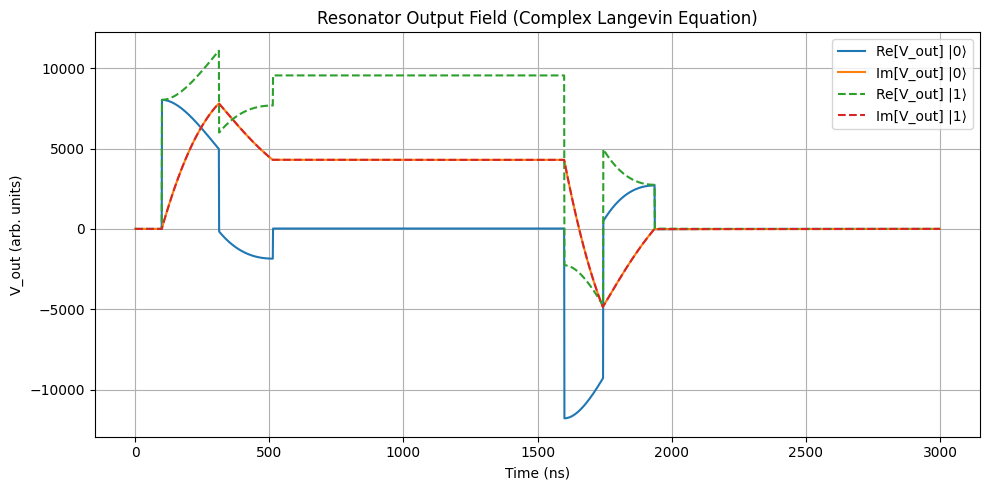

In [9]:
V_out_0 = np.sqrt(k) * a_0.flatten() + np.array([b_in(t) for t in tlist])
V_out_1 = np.sqrt(k) * a_1.flatten() + np.array([b_in(t) for t in tlist])

plt.figure(figsize=(10, 5))
plt.plot(tlist * 1e9, np.real(V_out_0).flatten(), label='Re[V_out] |0⟩')
plt.plot(tlist * 1e9, np.imag(V_out_0).flatten(), label='Im[V_out] |0⟩')
plt.plot(tlist * 1e9, np.real(V_out_1).flatten(), '--', label='Re[V_out] |1⟩')
plt.plot(tlist * 1e9, np.imag(V_out_1.flatten()), '--', label='Im[V_out] |1⟩')
plt.xlabel("Time (ns)")
plt.ylabel("V_out (arb. units)")
plt.title("Resonator Output Field (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

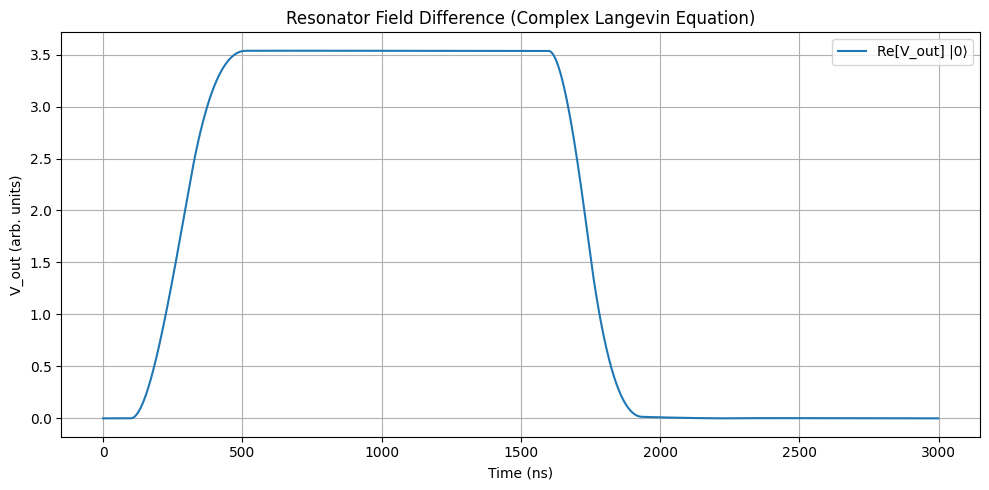

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(tlist * 1e9, abs(np.real(a_0)-np.real(a_1)), label='Re[V_out] |0⟩')
plt.xlabel("Time (ns)")
plt.ylabel("V_out (arb. units)")
plt.title("Resonator Field Difference (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

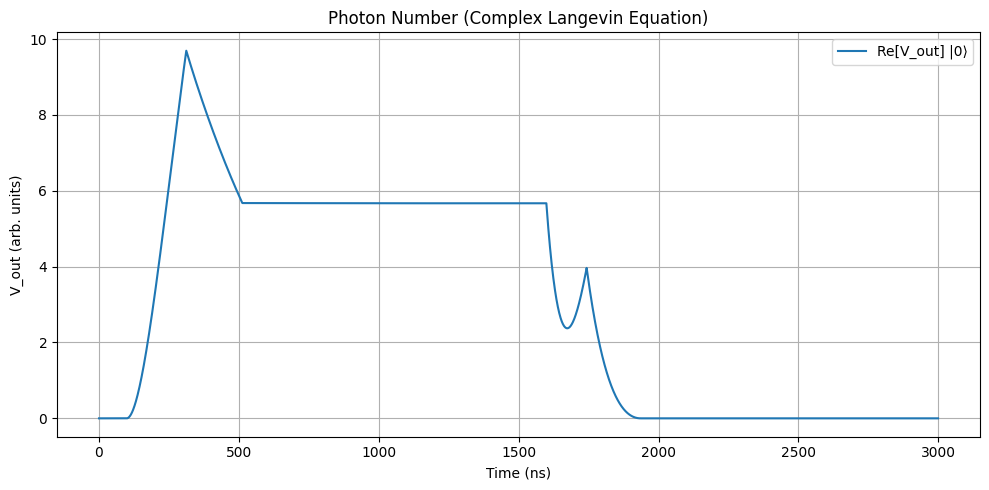

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(tlist * 1e9, abs(a_0**2), label='Re[V_out] |0⟩')
plt.xlabel("Time (ns)")
plt.ylabel("V_out (arb. units)")
plt.title("Photon Number (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

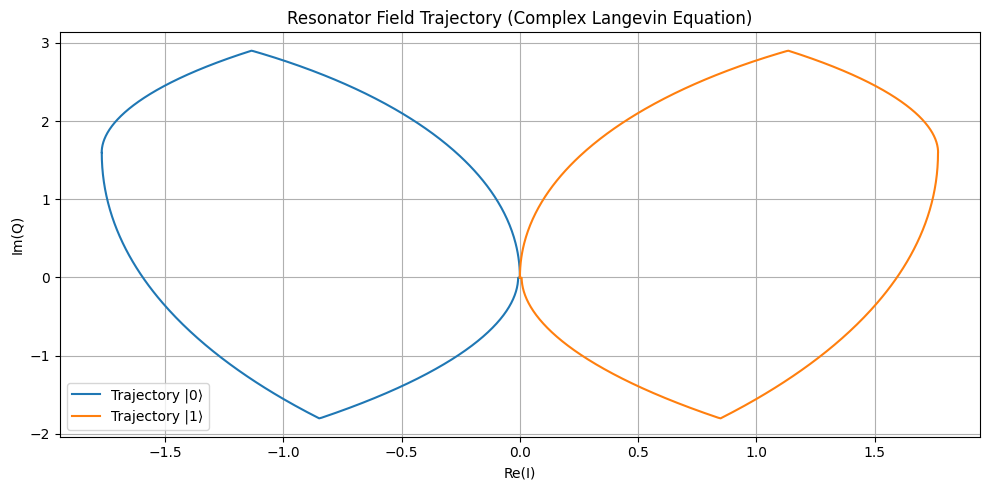

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(np.real(a_0), np.imag(a_0), label='Trajectory |0⟩')
plt.plot(np.real(a_1), np.imag(a_1), label='Trajectory |1⟩')
plt.xlabel("Re(I)")
plt.ylabel("Im(Q)")
plt.title("Resonator Field Trajectory (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Find drive amp for one photon

In [17]:
def get_photon(drive_amp):
    def b_in(t):
        return drive_amp

        # Define Heisenburg picture 
    def langevin(t, a_vec, qubit_state):
        omega_eff = chi * qubit_state
        return -1j * omega_eff * a_vec - (k / 2) * a_vec +  1j * np.sqrt(k) * b_in(t)

    def run_langevin(qubit_state):
        solver = ode(langevin)
        solver.set_integrator('zvode', method='bdf')  # complex-valued ODE solver
        solver.set_initial_value(0.0+0.0j, tlist[0])
        solver.set_f_params(qubit_state)

        a_vals = []

        for _ in range(len(tlist)):
            if not solver.successful():
                print("Integration failed at t =", solver.t)
                break
            solver.integrate(solver.t + dt)
            a_vals.append(solver.y)

        return np.array(a_vals)

    # Run for both qubit states
    a_0 = run_langevin(-1)
    photon_0 = np.abs(a_0)**2

    return photon_0[-1][0]

# Binary search for drive amplitude that yields photon ≈ 1
def tune_drive_for_photon(target_photon=1.0, lower=0.0,  upper=1e4, tol=1e-3, max_iter=50):
    for _ in range(max_iter):
        mid = (lower + upper) / 2
        photon_val = get_photon(mid)
        print(f"Drive = {mid:.4f}, Photon = {photon_val:.4f}")

        if abs(photon_val - target_photon) < tol:
            return mid
        elif photon_val < target_photon:
            lower = mid
        else:
            upper = mid
    raise RuntimeError("Did not converge within max iterations")

# Run it
optimal_drive = tune_drive_for_photon()
print(f"\n✅ Optimal drive amplitude to reach ⟨n⟩ ≈ 1: {optimal_drive:.4f}")

Drive = 5000.0000, Photon = 6.3980
Drive = 2500.0000, Photon = 1.5995
Drive = 1250.0000, Photon = 0.3999
Drive = 1875.0000, Photon = 0.8997
Drive = 2187.5000, Photon = 1.2246
Drive = 2031.2500, Photon = 1.0559
Drive = 1953.1250, Photon = 0.9763
Drive = 1992.1875, Photon = 1.0157
Drive = 1972.6562, Photon = 0.9959
Drive = 1982.4219, Photon = 1.0058
Drive = 1977.5391, Photon = 1.0008

✅ Optimal drive amplitude to reach ⟨n⟩ ≈ 1: 1977.5391


### Optimise CLEAR pulse

In [71]:
# Define metrics to analyse pulse effectiveness

def find_steady_state_time(tlist, photon_number, threshold=1e-5, window_size=200):
    start_offset = int(pulse_start* 1e9)
    photon_number = np.array(photon_number[start_offset:])
    tlist = np.array(tlist[start_offset:])

    for i in range(len(photon_number) - window_size):
        window = photon_number[i:i + window_size]
        if np.max(window) - np.min(window) < threshold:
            return tlist[i]
    
    return np.inf

def find_cavity_reset_time(tlist, photon_number, threshold=1e-5):
    offset = int((pulse_start + pulse_width) * 1e9)
    photon_number = np.array(photon_number[offset:])
    tlist = np.array(tlist[offset:])

    below = photon_number <= threshold

    for i in range(len(below)):
        if np.all(below[i:]):
            # Reset time is relative to when the pulse ends
            return tlist[i] - (pulse_start + pulse_width)

    return np.inf  # No such reset point found

In [37]:
def simulate_populate(ringup_time, ringdown_time, ringup_amp, ringdown_amp, drive_amp):
    def b_in(t):
        try:
            if  t<= pulse_start:
                return 0.0
            elif t<= pulse_start + ringup_time:
                return ringup_amp 
            elif t <= pulse_start + ringup_time + ringdown_time:
                return ringdown_amp
            else:
                return drive_amp
        
        except Exception as e:
            print(f"b_in error at t={t}: {e}")
            return 0.0

        # Define Heisenburg picture 
    def langevin(t, a_vec, qubit_state):
        omega_eff = chi * qubit_state
        return -1j * omega_eff * a_vec - (k / 2) * a_vec +  1j * np.sqrt(k) * b_in(t)

    def run_langevin(qubit_state):
        solver = ode(langevin)
        solver.set_integrator('zvode', method='bdf')  # complex-valued ODE solver
        solver.set_initial_value(0.0+0.0j, tlist[0])
        solver.set_f_params(qubit_state)

        a_vals = []

        for _ in range(len(tlist)):
            if not solver.successful():
                print("Integration failed at t =", solver.t)
                break
            solver.integrate(solver.t + dt)
            a_vals.append(solver.y)

        return np.array(a_vals)

    # Run for both qubit states
    a_0 = run_langevin(-1)
    photon_0 = np.abs(a_0)**2

    steady_state_time = find_steady_state_time(tlist, photon_0)

    return steady_state_time/1e-9

def simulate_reset(ringup_time, ringdown_time, ringup_amp, ringdown_amp, drive_amp):
    def b_in(t):
        try:
            if t <= pulse_start + pulse_width:
                return drive_amp
            elif t <= pulse_start + pulse_width + ringdown_time:
                return ringdown_amp 
            elif t <= pulse_start + pulse_width + ringdown_time + ringup_time:
                return ringup_amp
            else:   
                return 0.0
        
        except Exception as e:
            print(f"b_in error at t={t}: {e}")
            return 0.0

        # Define Heisenburg picture 
    def langevin(t, a_vec, qubit_state):
        omega_eff = chi * qubit_state
        return -1j * omega_eff * a_vec - (k / 2) * a_vec +  1j * np.sqrt(k) * b_in(t)

    def run_langevin(qubit_state):
        solver = ode(langevin)
        solver.set_integrator('zvode', method='bdf')  # complex-valued ODE solver
        solver.set_initial_value(0.0+0.0j, tlist[0])
        solver.set_f_params(qubit_state)

        a_vals = []

        for _ in range(len(tlist)):
            if not solver.successful():
                print("Integration failed at t =", solver.t)
                break
            solver.integrate(solver.t + dt)
            a_vals.append(solver.y)

        return np.array(a_vals)

    # Run for both qubit states
    a_0 = run_langevin(-1)
    photon_0 = np.abs(a_0)**2
    
    reset_time = find_cavity_reset_time(tlist, photon_0)

    return reset_time/1e-9

In [38]:
def simulate_populate_plot(ringup_time, ringdown_time, ringup_amp, ringdown_amp, drive_amp):
    def b_in(t):
        try:
            if  t<= pulse_start:
                return 0.0
            elif t<= pulse_start + ringup_time:
                return ringup_amp 
            elif t <= pulse_start + ringup_time + ringdown_time:
                return ringdown_amp
            else:
                return drive_amp
        
        except Exception as e:
            print(f"b_in error at t={t}: {e}")
            return 0.0

        # Define Heisenburg picture 
    def langevin(t, a_vec, qubit_state):
        omega_eff = chi * qubit_state
        return -1j * omega_eff * a_vec - (k / 2) * a_vec +  1j * np.sqrt(k) * b_in(t)

    def run_langevin(qubit_state):
        solver = ode(langevin)
        solver.set_integrator('zvode', method='bdf')  # complex-valued ODE solver
        solver.set_initial_value(0.0+0.0j, tlist[0])
        solver.set_f_params(qubit_state)

        a_vals = []

        for _ in range(len(tlist)):
            if not solver.successful():
                print("Integration failed at t =", solver.t)
                break
            solver.integrate(solver.t + dt)
            a_vals.append(solver.y)

        return np.array(a_vals)

    # Run for both qubit states
    a_0 = run_langevin(-1)
    photon_0 = np.abs(a_0)**2

    plt.figure(figsize=(10, 5))
    plt.plot(tlist * 1e9, photon_0, label='n |g⟩')
    plt.xlabel("Time (ns)")
    plt.ylabel("N (arb. units)")
    plt.title("Resonator Photon Number (Complex Langevin Equation)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def simulate_reset_plot(ringup_time, ringdown_time, ringup_amp, ringdown_amp, drive_amp):
    def b_in(t):
        try:
            if t <= pulse_start + pulse_width:
                return drive_amp
            elif t <= pulse_start + pulse_width + ringdown_time:
                return ringdown_amp 
            elif t <= pulse_start + pulse_width + ringdown_time + ringup_time:
                return ringup_amp
            else:   
                return 0.0
        
        except Exception as e:
            print(f"b_in error at t={t}: {e}")
            return 0.0

        # Define Heisenburg picture 
    def langevin(t, a_vec, qubit_state):
        omega_eff = chi * qubit_state
        return -1j * omega_eff * a_vec - (k / 2) * a_vec +  1j * np.sqrt(k) * b_in(t)

    def run_langevin(qubit_state):
        solver = ode(langevin)
        solver.set_integrator('zvode', method='bdf')  # complex-valued ODE solver
        solver.set_initial_value(0.0+0.0j, tlist[0])
        solver.set_f_params(qubit_state)

        a_vals = []

        for _ in range(len(tlist)):
            if not solver.successful():
                print("Integration failed at t =", solver.t)
                break
            solver.integrate(solver.t + dt)
            a_vals.append(solver.y)

        return np.array(a_vals)

    # Run for both qubit states
    a_0 = run_langevin(-1)
    photon_0 = np.abs(a_0)**2
    
    plt.figure(figsize=(10, 5))
    plt.plot(tlist * 1e9, photon_0, label='n |g⟩')
    plt.xlabel("Time (ns)")
    plt.ylabel("N (arb. units)")
    plt.title("Resonator Photon Number (Complex Langevin Equation)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# === Your Cost Function ===
def steady_cost(params):
    cost = simulate_populate(*params)
    print(f"Params: {params} → Cost: {cost if cost is not None else 'N/A'}")

    return cost

# === Parameter Bounds ===
bounds = [(1e-9, 200e-9),      # Ringup time
          (1e-9, 200e-9),      # Ringdown time
          (0.1e3, 15e3),        # Ringup norm
          (0.1e3, 15e3),        # Ringdown norm
          (0.1e3, 15e3)]        # Drive norm

# Extract separate lower and upper bound lists
lower_bounds, upper_bounds = zip(*bounds)

# === Initial Guess and Sigma ===
# x0 = [(low + high) / 2 for low, high in bounds]  # Midpoint
x0 = [10e-9, 10e-9, 10e3, 0.1e3, 2e3]  # Initial guess
sigmas = [(high - low) * 0.3 for (low, high) in bounds]

# === CMA-ES Optimization ===
es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=0.3,
    inopts={
        'bounds': [list(lower_bounds), list(upper_bounds)],
        'maxiter': 200,
        'CMA_stds': sigmas,
        'verb_disp': 1,
    }
)

# Run the optimization
res = es.optimize(steady_cost)

# Best solution and its cost
# ringup_time, ringdown_time, ringup_norm, ringdown_norm, drive_norm
print("Best stabilisation time:", res.result.fbest)
params_steady = res.result.xbest
print(f"Stabilisation optimal ringup_time: {params_steady[0]/1e-9} ns, ringdown_time {params_steady[1]/1e-9} ns, ringup_norm {params_steady[2]/1e3} kV, ringdown_norm {params_steady[3]/1e3} kV, drive_norm {params_steady[4]/1e3} kV")


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=836062, Tue Jun 24 13:51:18 2025)
Params: [1.04333942e-08 1.10691341e-08 1.06890509e+04 1.48509333e+03
 2.10153650e+03] → Cost: inf
Params: [2.68589418e-09 7.83300009e-09 1.08085637e+04 1.31878874e+03
 6.69008691e+02] → Cost: inf
Params: [8.16215042e-09 4.53955819e-09 1.27972119e+04 1.76951726e+03
 1.18921058e+03] → Cost: inf
Params: [1.56076240e-08 5.96490266e-09 1.15230770e+04 6.40502804e+02
 5.63748780e+02] → Cost: inf
Params: [7.95368912e-09 6.78225118e-09 9.64640285e+03 2.02541709e+02
 3.70589052e+03] → Cost: inf
Params: [1.06323214e-08 7.36654198e-09 9.50460158e+03 2.04455592e+03
 1.97991361e+03] → Cost: inf
Params: [6.32223288e-09 2.05098146e-08 1.06139367e+04 6.78007722e+02
 1.52348264e+03] → Cost: inf
Params: [2.99767530e-09 1.89103339e-08 8.55729162e+03 9.20404130e+02
 1.10644245e+03] → Cost: inf
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 inf 1.0e+00 2.95e-01  2e-08  1e+03 0:00.1

/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 1, 2, 3, 4, 5, 6, 7] are not finite but [inf, inf, inf, inf, inf, inf, inf, inf]. (time=Jun 24 13:51:18 2025 class=CMAEvolutionStrategy method=ask)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/cma/evolution_strategy.py:3429: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 1, 2, 3, 4, 6, 7] are not finite but [inf, inf, inf, inf, inf, inf, inf]. (time=Jun 24

Params: [1.75967687e-09 7.21632227e-09 1.38456058e+04 8.20809030e+02
 1.02727048e+03] → Cost: inf
Params: [1.14432594e-09 1.71477660e-08 1.05792851e+04 1.30491188e+03
 1.85164746e+03] → Cost: inf
Params: [1.08382610e-09 5.69829874e-09 1.12213393e+04 1.40305816e+03
 1.60629569e+03] → Cost: inf
Params: [1.10413649e-08 1.33712791e-08 1.10954384e+04 2.46354582e+02
 4.01512365e+03] → Cost: inf
Params: [3.77208121e-09 6.70070179e-09 1.13991363e+04 1.79951681e+03
 7.54460702e+02] → Cost: inf
Params: [1.27733186e-09 6.55915787e-09 1.13628062e+04 1.93606280e+03
 8.17517395e+02] → Cost: inf
Params: [1.04016126e-09 1.73347406e-08 1.13706737e+04 2.46945600e+03
 2.32451106e+03] → Cost: inf
Params: [1.24043373e-08 1.24548328e-08 1.10413222e+04 7.02324217e+02
 1.33831853e+03] → Cost: inf
    3     24 inf 1.6e+00 3.47e-01  2e-08  2e+03 0:00.5
Params: [1.04707692e-09 5.40943173e-09 1.32401789e+04 2.55244589e+03
 2.38496125e+02] → Cost: inf
Params: [1.99151297e-09 3.95717876e-09 1.33729929e+04 8.9911951

/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 1, 2, 3, 4, 5, 6, 7] are not finite but [inf, inf, inf, inf, inf, inf, inf, inf]. (time=Jun 24 13:51:18 2025 class=CMAEvolutionStrategy method=ask iteration=2)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 1, 2, 3, 4, 5, 6, 7] are not finite but [inf, inf, inf, inf, inf, inf, inf, inf]. (time=Jun 24 13:51:19 2025 class=CMAEvolutionStrategy method=ask iteration=3)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


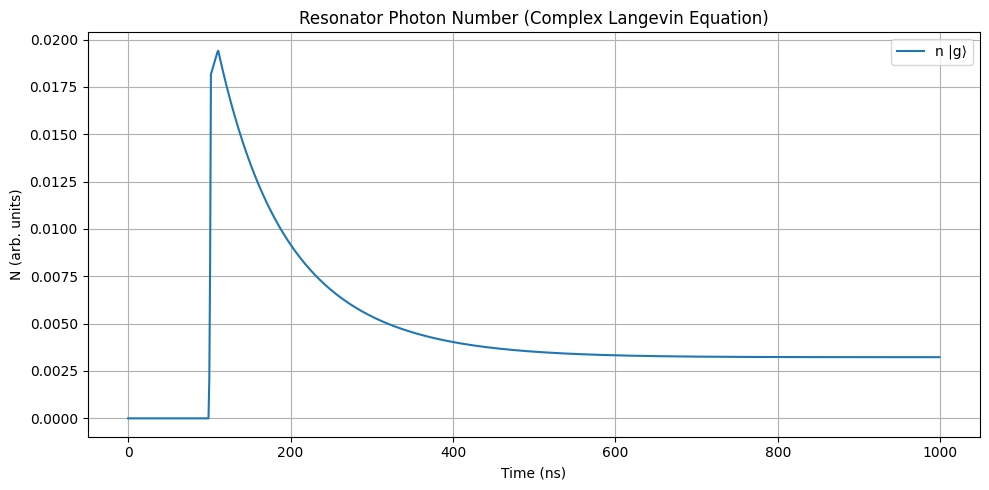

In [91]:
simulate_populate_plot(*params_steady)


In [73]:
optimal_drive = params_steady[4]

# === Your Cost Function ===
def reset_cost(params):
    params = np.append(params, optimal_drive)
    cost = simulate_reset(*params)
    print(f"Params: {params} → Cost: {cost if cost is not None else 'N/A'}")

    return cost

# === Parameter Bounds ===
bounds = [(1e-9, 500e-9),      # Ringup time
          (1e-9, 500e-9),      # Ringdown time
          (1, 15e3),        # Ringup norm
          (-15e3, -1),        # Ringdown norm
          ]        # Drive norm

# Extract separate lower and upper bound lists
lower_bounds, upper_bounds = zip(*bounds)

# === Initial Guess and Sigma ===
x0 = [50e-9, 50e-9, 1e3, -5e3]  # Initial guess
sigmas = [(high - low) * 0.3 for (low, high) in bounds]

# === CMA-ES Optimization ===
es = cma.CMAEvolutionStrategy(
    x0=x0,
    sigma0=0.3,
    inopts={
        'bounds': [list(lower_bounds), list(upper_bounds)],
        'maxiter': 100,
        'CMA_stds': sigmas,
        'verb_disp': 1,
    }
)

# Run the optimization
res = es.optimize(reset_cost)

# Best solution and its cost
# ringup_time, ringdown_time, ringup_norm, ringdown_norm, drive_norm
print("Best reset time:", res.result.fbest)
params_reset = res.result.xbest
params_reset = np.append(params_reset, optimal_drive)

print(f"Reset optimal ringup_time: {params_reset[0]/1e-9} ns, ringdown_time {params_reset[1]/1e-9} ns, ringup_norm {params_reset[2]/1e3} kV, ringdown_norm {params_reset[3]/1e3} kV, drive_norm {params_reset[4]/1e3} kV")


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=799867, Tue Jun 24 13:50:22 2025)
Params: [ 6.89337307e-08  4.43795072e-08  8.40364055e+02 -3.56129353e+03
  1.07098497e+02] → Cost: inf
Params: [ 3.58447530e-08  8.55239375e-08  1.01011031e+02 -4.69414332e+03
  1.07098497e+02] → Cost: inf
Params: [ 7.45759524e-08  7.18251477e-08  1.26989331e+03 -5.27482443e+03
  1.07098497e+02] → Cost: inf
Params: [ 6.00663746e-08  2.62260468e-08  1.59949386e+03 -5.25355065e+03
  1.07098497e+02] → Cost: 376.00000000000006
Params: [ 6.40755105e-08  4.52456890e-08  8.06378188e+02 -5.27220515e+03
  1.07098497e+02] → Cost: inf
Params: [ 3.25299905e-08  1.15274029e-07  5.01370471e+02 -3.76718087e+03
  1.07098497e+02] → Cost: inf
Params: [ 7.66228769e-08  2.09989946e-08  5.07638322e+02 -5.33593739e+03
  1.07098497e+02] → Cost: inf
Params: [ 6.98989297e-08  7.33195064e-08  1.17691661e+03 -5.77811335e+03
  1.07098497e+02] → Cost: inf
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]

/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 1, 2, 4, 5, 6, 7] are not finite but [inf, inf, inf, inf, inf, inf, inf]. (time=Jun 24 13:50:22 2025 class=CMAEvolutionStrategy method=ask)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 1, 2, 3, 4, 5, 6, 7] are not finite but [inf, inf, inf, inf, inf, inf, inf, inf]. (time=Jun 24 13:50:22 2025 class=CMAEvolutionStrategy method=ask iteration=1)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [ 3.55154978e-08  5.92506228e-08  1.99156612e+03 -6.05087496e+03
  1.07098497e+02] → Cost: inf
Params: [ 3.00925495e-08  5.25808469e-08  2.00190836e+02 -6.33787255e+03
  1.07098497e+02] → Cost: inf
Params: [ 8.64499406e-08  5.76845239e-08  1.67051950e+03 -4.88170648e+03
  1.07098497e+02] → Cost: inf
Params: [ 4.81625099e-08  1.80963446e-08  6.02008006e+02 -6.07343021e+03
  1.07098497e+02] → Cost: inf
Params: [ 5.69773581e-08  8.30372596e-08  3.60408177e+02 -4.42463675e+03
  1.07098497e+02] → Cost: inf
Params: [ 4.09441407e-08  5.52918632e-08  1.10257032e+03 -4.36263322e+03
  1.07098497e+02] → Cost: inf
Params: [ 6.69225696e-08  3.77173673e-08  1.38801501e+03 -4.31749011e+03
  1.07098497e+02] → Cost: 385.0000000000001
Params: [ 4.67449395e-08  4.43984092e-08  3.82903190e+02 -5.60457161e+03
  1.07098497e+02] → Cost: inf
    3     24 3.850000000000001e+02 1.4e+00 2.46e-01  3e-08  1e+03 0:00.4
Params: [ 5.53830887e-08  6.23683347e-08  2.10610235e+02 -5.14997897e+03
  1.07098497e+02

/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 1, 2, 3, 4, 5, 7] are not finite but [inf, inf, inf, inf, inf, inf, inf]. (time=Jun 24 13:50:22 2025 class=CMAEvolutionStrategy method=ask iteration=2)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 1, 2, 3, 4, 5, 6, 7] are not finite but [inf, inf, inf, inf, inf, inf, inf, inf]. (time=Jun 24 13:50:22 2025 class=CMAEvolutionStrategy method=ask iteration=3)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


Params: [ 7.09471846e-08  5.20992204e-08  7.28766486e+02 -4.77218303e+03
  1.07098497e+02] → Cost: inf
Params: [ 6.07867646e-08  6.86893643e-08  2.09225407e+03 -5.80292277e+03
  1.07098497e+02] → Cost: inf
Params: [ 4.84663212e-08  5.64515476e-08  5.23184772e+02 -5.26834929e+03
  1.07098497e+02] → Cost: inf
Params: [ 5.81645707e-08  4.81263751e-08  9.16545627e+01 -5.34236277e+03
  1.07098497e+02] → Cost: inf
    5     40 inf 1.7e+00 1.74e-01  2e-08  8e+02 0:00.6
Best reset time: 376.00000000000006
Reset optimal ringup_time: 60.06637456315775 ns, ringdown_time 26.226046812335337 ns, ringup_norm 1.599493862051349 kV, ringdown_norm -5.253550652631274 kV, drive_norm 0.10709849659516321 kV


/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/cma/utilities/utils.py:349: UserWarning: function values with index [0, 1, 2, 3, 4, 5, 6, 7] are not finite but [inf, inf, inf, inf, inf, inf, inf, inf]. (time=Jun 24 13:50:22 2025 class=CMAEvolutionStrategy method=ask iteration=4)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +


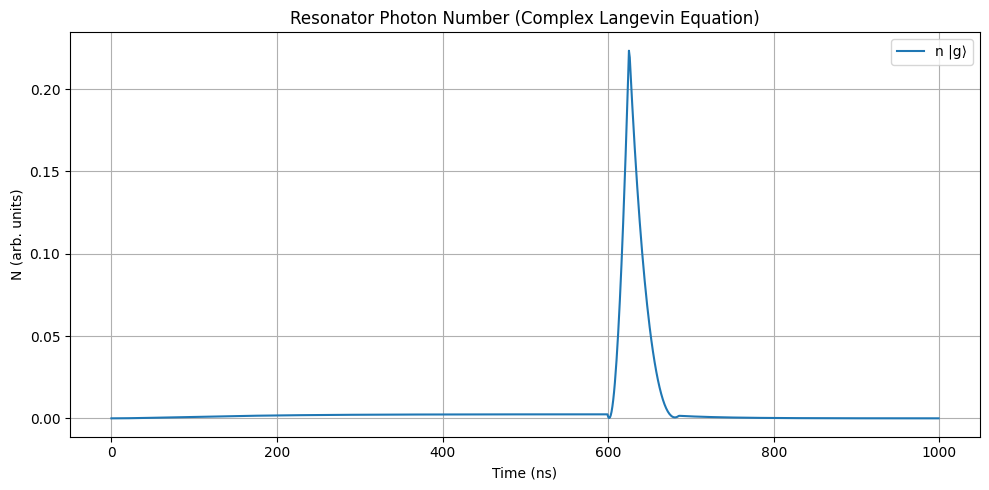

In [74]:
simulate_reset_plot(*params_reset)

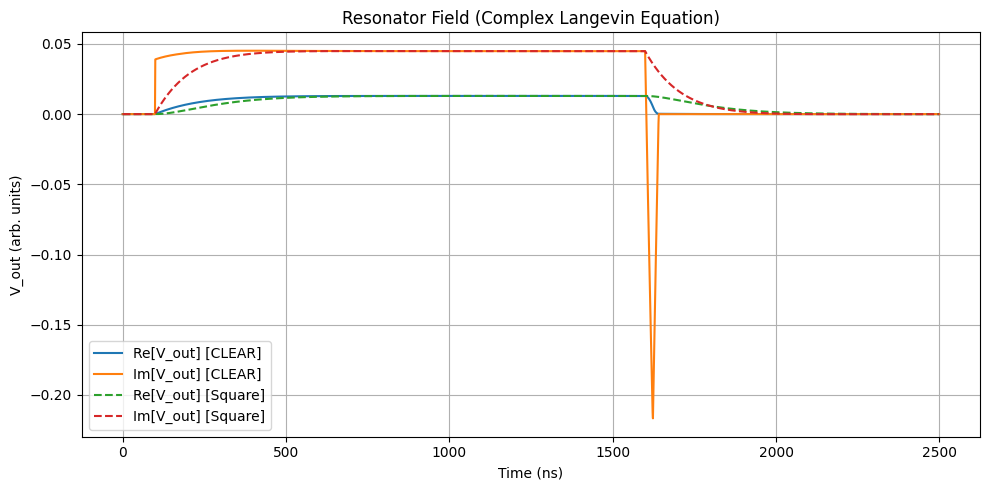

In [174]:
ringup1_amp = params_steady[2]
ringdown1_amp = params_steady[3]
ringup2_amp = params_reset[2]
drive_amp = params_steady[4]
ringdown2_amp = params_reset[3]

optimal_ringup1_time = params_steady[0]
optimal_ringdown1_time = params_steady[1]
optimal_ringup2_time = params_reset[0]
optimal_ringdown2_time = params_reset[1]

# Define drive
def b_in(t):
    try:
        if  t<= pulse_start:
            return 0.0
        elif t<= pulse_start + optimal_ringup1_time:
            return ringup1_amp 
        elif t <= pulse_start + optimal_ringup1_time + optimal_ringdown1_time:
            return ringdown1_amp
        elif t <= pulse_start + pulse_width:
            return drive_amp
        elif t <= pulse_start + pulse_width + optimal_ringdown2_time:
            return ringdown2_amp 
        elif t <= pulse_start + pulse_width + optimal_ringdown2_time + optimal_ringup2_time:
            return ringup2_amp
        else:   
            return 0.0
    
    except Exception as e:
        print(f"b_in error at t={t}: {e}")
        return 0.0
    
def b_in_square(t):
    try:
        if  t<= pulse_start:
            return 0.0
        elif t <= pulse_start + pulse_width:
            return drive_amp
        else:   
            return 0.0
    
    except Exception as e:
        print(f"b_in error at t={t}: {e}")
        return 0.0

# Define Heisenburg picture 
def langevin(t, a_vec, qubit_state):
    omega_eff = chi * qubit_state
    return -1j * omega_eff * a_vec - (k / 2) * a_vec +  1j * np.sqrt(k) * b_in(t)

def langevin_square(t, a_vec, qubit_state):
    omega_eff = chi * qubit_state
    return -1j * omega_eff * a_vec - (k / 2) * a_vec +  1j * np.sqrt(k) * b_in_square(t)

def run_langevin(qubit_state):
    solver = ode(langevin)
    solver.set_integrator('zvode', method='bdf')  # complex-valued ODE solver
    solver.set_initial_value(0.0+0.0j, tlist[0])
    solver.set_f_params(qubit_state)

    a_vals = []

    for _ in range(len(tlist)):
        if not solver.successful():
            print("Integration failed at t =", solver.t)
            break
        solver.integrate(solver.t + dt)
        a_vals.append(solver.y)

    return np.array(a_vals)

def run_langevin_square(qubit_state):
    solver = ode(langevin_square)
    solver.set_integrator('zvode', method='bdf')  # complex-valued ODE solver
    solver.set_initial_value(0.0+0.0j, tlist[0])
    solver.set_f_params(qubit_state)

    a_vals = []

    for _ in range(len(tlist)):
        if not solver.successful():
            print("Integration failed at t =", solver.t)
            break
        solver.integrate(solver.t + dt)
        a_vals.append(solver.y)

    return np.array(a_vals)

# Run for both qubit states
a_0 = run_langevin(1)
a_s = run_langevin_square(1)

plt.figure(figsize=(10, 5))
plt.plot(tlist * 1e9, np.real(a_0), label='Re[V_out] [CLEAR]')
plt.plot(tlist * 1e9, np.imag(a_0), label='Im[V_out] [CLEAR]')
plt.plot(tlist * 1e9, np.real(a_s), '--', label='Re[V_out] [Square]')
plt.plot(tlist * 1e9, np.imag(a_s), '--', label='Im[V_out] [Square]')
plt.xlabel("Time (ns)")
plt.ylabel("V_out (arb. units)")
plt.title("Resonator Field (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


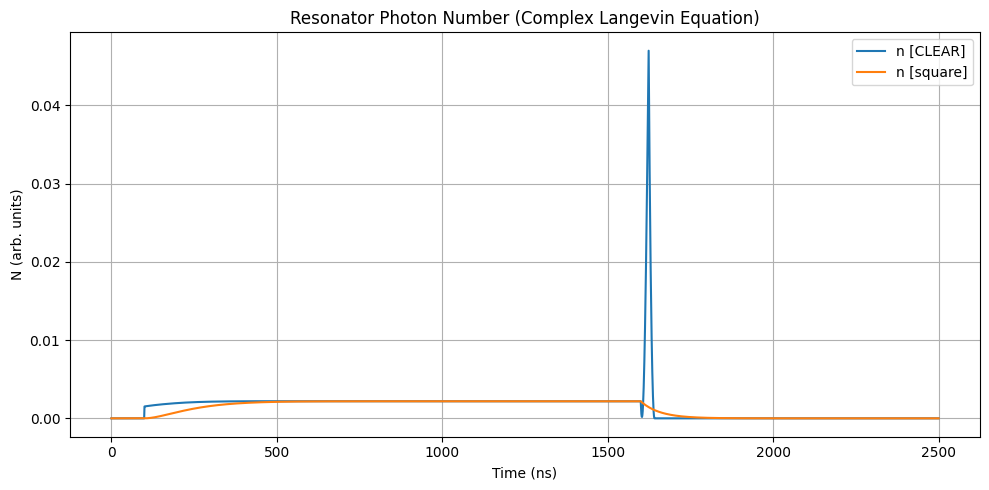

In [175]:
# Use the photon number as metric for optimising CLEAR pulse

photon_0 = np.abs(a_0)**2
photon_s = np.abs(a_s)**2

plt.figure(figsize=(10, 5))
plt.plot(tlist * 1e9, photon_0, label='n [CLEAR]')
plt.plot(tlist * 1e9, photon_s, label='n [square]')
plt.xlabel("Time (ns)")
plt.ylabel("N (arb. units)")
plt.title("Resonator Photon Number (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [176]:
# Calculate steady and reset time for the 2 pulses
steady_time_clear = find_steady_state_time(tlist, photon_0)
steady_time_square = find_steady_state_time(tlist, photon_s)
reset_time_clear = find_cavity_reset_time(tlist, photon_0)
reset_time_square = find_cavity_reset_time(tlist, photon_s)
print(f"Steady state time CLEAR: {steady_time_clear/1e-9:.2f} ns")
print(f"Steady state time square: {steady_time_square/1e-9:.2f} ns")
print(f"Reset time CLEAR: {reset_time_clear/1e-9:.2f} ns")
print(f"Reset time square: {reset_time_square/1e-9:.2f} ns")

Steady state time CLEAR: 393.00 ns
Steady state time square: 641.00 ns
Reset time CLEAR: 41.00 ns
Reset time square: 573.00 ns


### Interaction with the readout resonator (Lab Frame)

In [4]:
# Define drive
def envelope(t):
    # Define all transitions using smooth ramps or precomputed segments
    if t <= pulse_start:
        return 0.0
    elif t <= pulse_start + optimal_ringup1_time:
        return ringup1_amp
    elif t <= pulse_start + optimal_ringup1_time + optimal_ringdown1_time:
        return ringdown1_amp
    elif t <= pulse_start + pulse_width:
        return drive_amp
    elif t <= pulse_start + pulse_width + optimal_ringdown2_time:
        return ringdown2_amp
    elif t <= pulse_start + pulse_width + optimal_ringdown2_time + optimal_ringup2_time:
        return ringup2_amp
    else:
        return 0.0
    
def b_in(t):
    env = envelope(t) * np.exp(1j * (wr_if * t + phi))
    return np.real(env) * np.cos(wr_lo * t) - np.imag(env) * np.sin(wr_lo * t)

def langevin(t, a, sigma_z):
    omega_eff = wr + chi * sigma_z
    return -1j * omega_eff * a - (k / 2) * a + 1j * np.sqrt(k) * b_in(t)

def run_langevin(sigma_z):
    solver = ode(langevin)
    solver.set_integrator('zvode', method='bdf')
    solver.set_initial_value(0.0+0.0j, tlist[0])
    solver.set_f_params(sigma_z)

    a_vals = []
    for i in range(len(tlist)):
        if not solver.successful():
            print(f'F {i} {solver.t} {sigma_z}')
            break
        solver.integrate(solver.t + dt)
        a_vals.append(solver.y)

    return np.array(a_vals)

# Simulate for qubit in |0⟩ and |1⟩ (σ_z = +1 and -1)
a_0 = run_langevin(-1)
a_1 = run_langevin(+1)

### RF response from the resonator: input-output theory

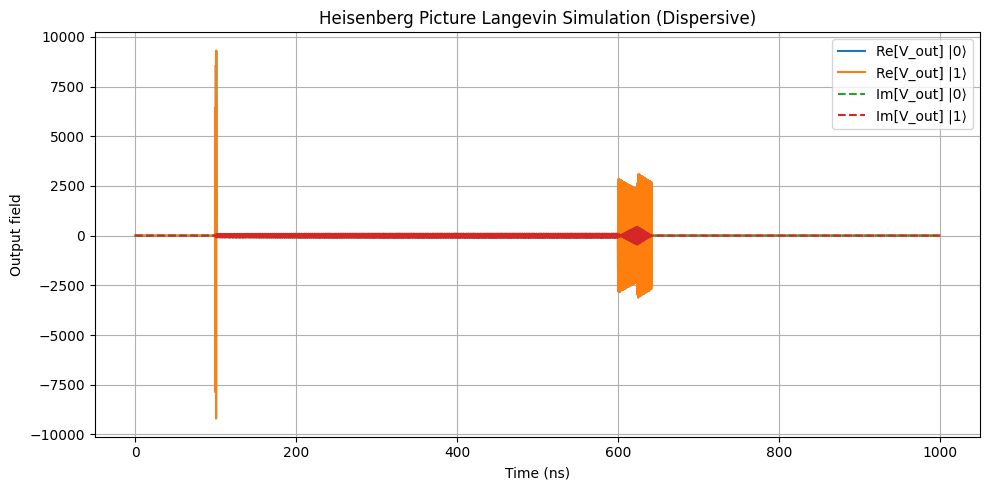

In [5]:
# Compute output field
V_out_0 = np.sqrt(k) * a_0.flatten() + np.array([b_in(t) for t in tlist.flatten()])
V_out_1 = np.sqrt(k) * a_1.flatten() + np.array([b_in(t) for t in tlist.flatten()])

# Plot
plt.figure(figsize=(10,5))
plt.plot(tlist * 1e9, np.real(V_out_0), label="Re[V_out] |0⟩")
plt.plot(tlist * 1e9, np.real(V_out_1), label="Re[V_out] |1⟩")
plt.plot(tlist * 1e9, np.imag(V_out_0), '--', label="Im[V_out] |0⟩")
plt.plot(tlist * 1e9, np.imag(V_out_1), '--', label="Im[V_out] |1⟩")
plt.xlabel("Time (ns)")
plt.ylabel("Output field")
plt.title("Heisenberg Picture Langevin Simulation (Dispersive)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Real value conversion as only real values transmitted along voltage line
V_out_1 = np.real(V_out_1)
V_out_0 = np.real(V_out_0)

### Demodulation of the RF signal

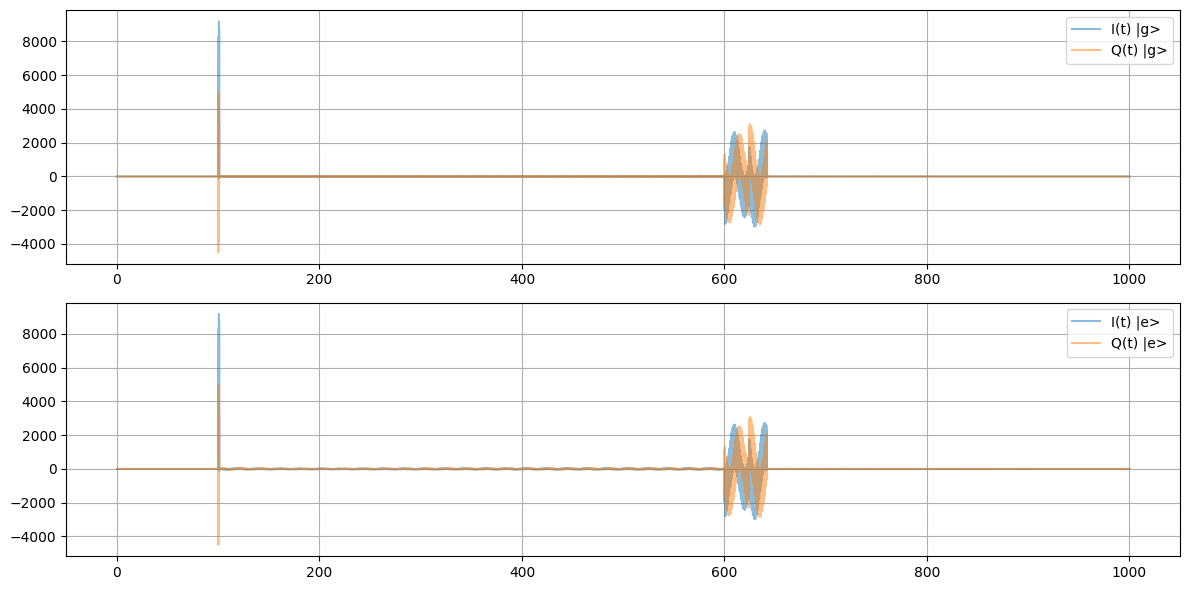

In [7]:
# Demodulation: complex demodulation
V_down_0_I = V_out_0 * np.cos(wr_lo * tlist)
V_down_0_Q = - V_out_0 * np.sin(wr_lo * tlist)
V_down_1_I = V_out_1 * np.cos(wr_lo * tlist)
V_down_1_Q = - V_out_1 * np.sin(wr_lo * tlist)

V_down_0 = V_down_0_I + 1j * V_down_0_Q
V_down_1 = V_down_1_I + 1j * V_down_1_Q

# V_down_0 = V_out_0 * np.exp(-1j * w_lo * tlist)
# V_down_1 = V_out_1 * np.exp(-1j * w_lo * tlist)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(tlist * 1e9, np.real(V_down_0), label="I(t) |g>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_down_0), label="Q(t) |g>", alpha=0.5)
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(tlist * 1e9, np.real(V_down_1), label="I(t) |e>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_down_1), label="Q(t) |e>", alpha=0.5)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

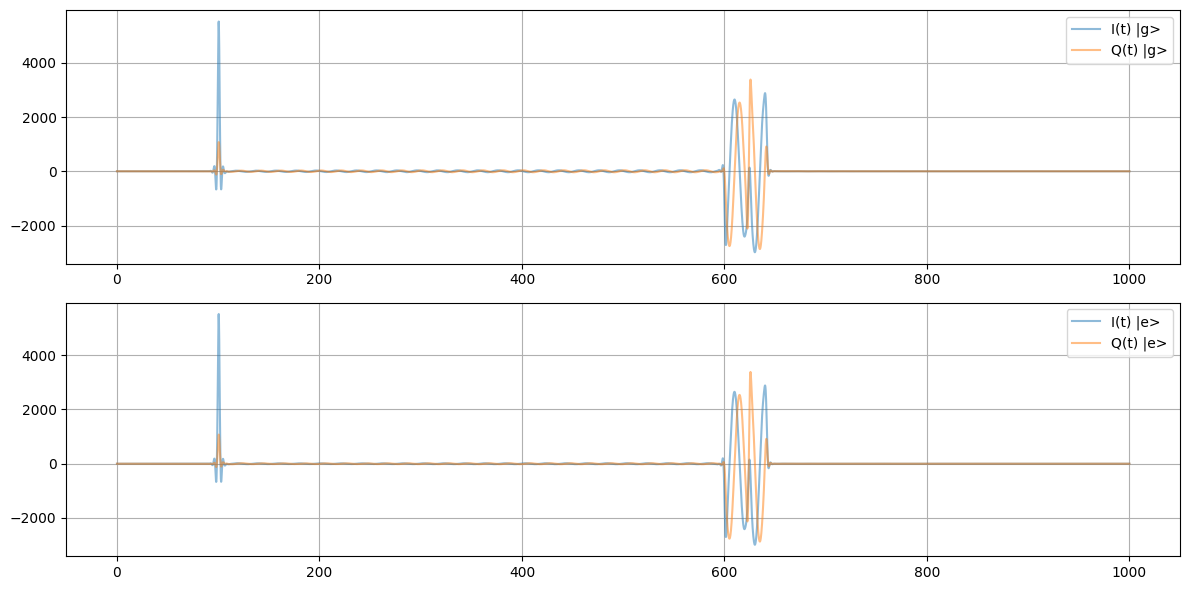

In [8]:
cutoff_frequency_if = 2 * wr_lo/(2*np.pi) # Hz
sampling_rate_if = 5e11 # Hz
order = 4

# Calculate normalized cutoff frequency
nyquist_frequency_if = 0.5 * sampling_rate_if
normalized_cutoff_if = cutoff_frequency_if / nyquist_frequency_if

# Design the Butterworth filter
sos_if = butter(order, normalized_cutoff_if, btype='low', analog=False, output='sos')
V_down_0 = 2 * sosfiltfilt(sos_if, V_down_0) # Restore magnitude from downconversion
V_down_1 = 2 * sosfiltfilt(sos_if, V_down_1)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(tlist * 1e9, np.real(V_down_0), label="I(t) |g>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_down_0), label="Q(t) |g>", alpha=0.5)
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(tlist * 1e9, np.real(V_down_1), label="I(t) |e>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_down_1), label="Q(t) |e>", alpha=0.5)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


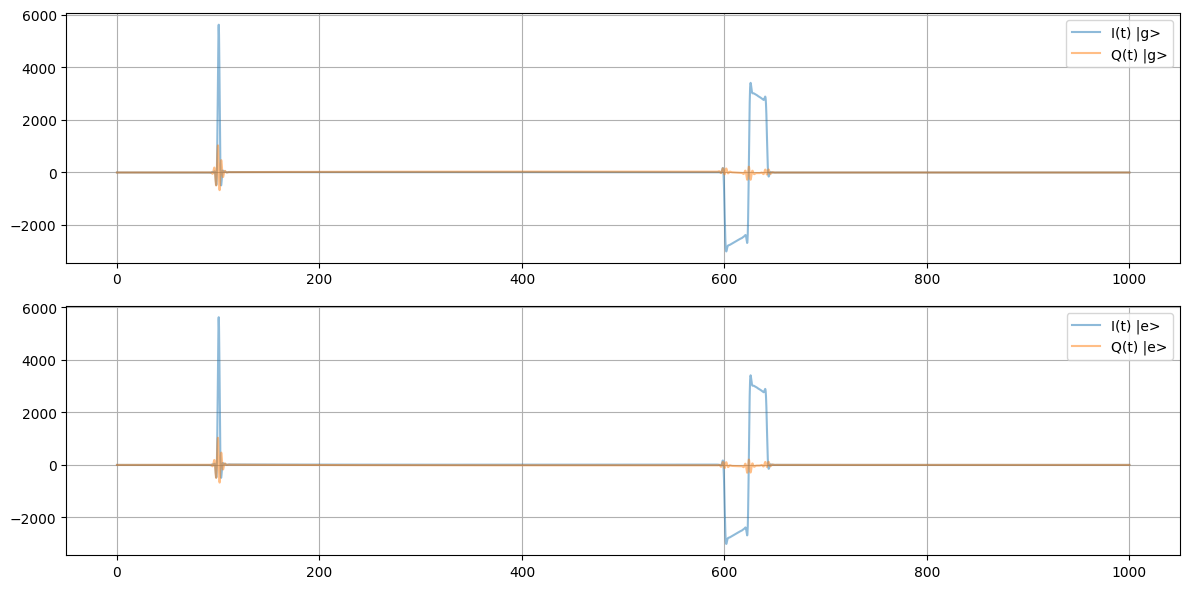

In [12]:
V_baseband_0 = V_down_0 * np.exp(-1j * wr_if * tlist)
V_baseband_1 = V_down_1 * np.exp(-1j * wr_if * tlist)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(tlist * 1e9, np.real(V_baseband_0), label="I(t) |g>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_baseband_0), label="Q(t) |g>", alpha=0.5)
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(tlist * 1e9, np.real(V_baseband_1), label="I(t) |e>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_baseband_1), label="Q(t) |e>", alpha=0.5)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

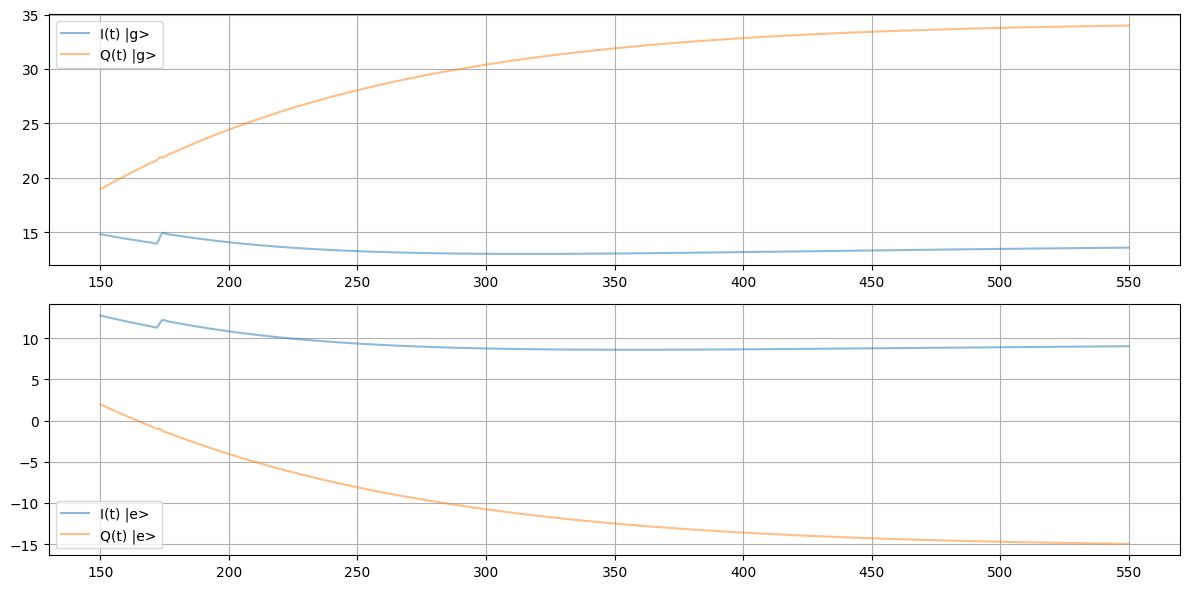

In [28]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(tlist[1500:5500] * 1e9, np.real(V_baseband_0[1500:5500]), label="I(t) |g>", alpha=0.5)
plt.plot(tlist[1500:5500] * 1e9, np.imag(V_baseband_0[1500:5500]), label="Q(t) |g>", alpha=0.5)
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(tlist[1500:5500] * 1e9, np.real(V_baseband_1[1500:5500]), label="I(t) |e>", alpha=0.5)
plt.plot(tlist[1500:5500] * 1e9, np.imag(V_baseband_1[1500:5500]), label="Q(t) |e>", alpha=0.5)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Integration Weights and Integration

In [32]:
pulse_start = 100e-9
pulse_width = 500e-9
steady_time = 393e-9

integration_start = pulse_start + steady_time
integration_duration = pulse_start + pulse_width
integration_mask = (tlist >= integration_start) & (tlist < integration_start + integration_duration)
integration_time = tlist[integration_mask]

# Optimal integration weights: normalised average trace difference
envelope_diff = V_baseband_0 - V_baseband_1
norm = np.max(np.abs(envelope_diff))
norm_envelope_diff = envelope_diff / norm

# weights = {}
# integration_weights = {}
# weights["I"] = np.array(
#     [np.real(norm_envelope_diff).tolist(), (np.imag(norm_envelope_diff)).tolist()]
# )
# weights["Q"] = np.array(
#     [np.imag(-norm_envelope_diff).tolist(), np.real(norm_envelope_diff).tolist()]
# )
# cos_weights = {"cosine": weights["I"][0], "sine": weights["I"][1]}
# sin_weights = {"cosine": weights["Q"][0], "sine": weights["Q"][1]}

# integration_weights["cos"] = cos_weights
# integration_weights["sin"] = sin_weights

# Calculate the demodulated signal using the optimal weights


w = np.conj(V_baseband_0 - V_baseband_1)
w /= np.linalg.norm(w)  # Normalize

S_g = np.sum((V_baseband_0 * w)) 
S_e = np.sum((V_baseband_1 * w)) 
S_g_masked = np.sum((V_baseband_0 * w)[integration_mask])
S_e_masked = np.sum((V_baseband_1 * w)[integration_mask])

print(f"Demodulated signal |g> S = {S_g:} (magnitude = {np.abs(S_g):}, phase = {np.angle(S_g):} rad)")
print(f"Demodulated signal |e> S = {S_e:} (magnitude = {np.abs(S_e):}, phase = {np.angle(S_e):} rad)")
print(f"Demodulated signal |g> S = {S_g_masked:} (magnitude = {np.abs(S_g_masked):}, phase = {np.angle(S_g_masked):} rad)")
print(f"Demodulated signal |e> S = {S_e_masked:} (magnitude = {np.abs(S_e_masked):}, phase = {np.angle(S_e_masked):} rad)")

Demodulated signal |g> S = (820.9511123943656+6723.420681494852j) (magnitude = 6773.355622532619, phase = 1.4492945855494344 rad)
Demodulated signal |e> S = (-2132.178293463995+6723.420681494852j) (magnitude = 7053.408391371631, phase = 1.877890978461461 rad)
Demodulated signal |g> S = (-671.2625714518293+7218.5148281978645j) (magnitude = 7249.65859642677, phase = 1.663521445043297 rad)
Demodulated signal |e> S = (-1683.4705403208366+7218.5148281978645j) (magnitude = 7412.221622768749, phase = 1.799916638731659 rad)


### Plotting measurement on complex I/Q plane

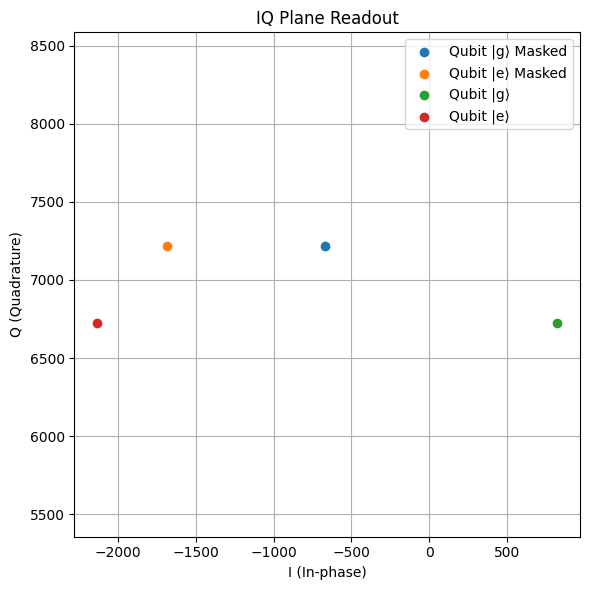

In [33]:
plt.figure(figsize=(6, 6))

plt.scatter(S_g_masked.real, S_g_masked.imag, label='Qubit |g⟩ Masked')
plt.scatter(S_e_masked.real, S_e_masked.imag, label='Qubit |e⟩ Masked')
plt.scatter(S_g.real, S_g.imag, label='Qubit |g⟩')
plt.scatter(S_e.real, S_e.imag, label='Qubit |e⟩')
plt.xlabel("I (In-phase)")
plt.ylabel("Q (Quadrature)")
plt.title("IQ Plane Readout")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()